# Ценообразование наборов в онлайн сервисе поддержки приютов для животных

Аналитик проекта: Постникова Екатерина

1. [Описание и цели](#objectives)
2. [Обзор и предобработка данных](#preprocessing)
3. [Исследовательский анализ данных](#eda)
    * [Обработка "выбросов" по наборам](#outliers)
    * [Характеристики пользователей сервиса](#users)
    * [Выручка по наборам](#revenue)
4. [Моделирование оптимальной цены](#modeling)
    * [Концепция ценообразования](#model)
    * [Прогноз модели нового ценообразования](#prediction)
5. [Вывод и рекомендации](#summary)
6. [Ссылки на результаты исследования](#results)

In [1]:
#проверка и установка необходимых библиотек
import sys
import subprocess
import pkg_resources

required = {'pandas', 'seaborn', 'matplotlib', 'numpy', 'sklearn'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [2]:
#импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import warnings; warnings.filterwarnings(action='ignore')

<a id="objectives"></a>
## Описание и цели

В онлайн сервисе **Teddy Food** пользователи помогают бездомным собакам и кошкам из приютов по всей стране. Сервис дает возможность пользователям кормить, ухаживать, дарить приятности и наблюдать за питомцами в режиме реального времени. За действия на сайте пользователи получают TF баллы, которые можно потратить в сервисы. 

Пользователи могут приобретать Наборы - это Котодень, КотоНеделя, КотоМесяц (аналогично по собакам). Оптимальное - с наибольшей выгодой по обороту. Чем больше человек тратит в проекте, тем больше получит приют и животные.

**Цель проекта:**

- Определить оптимальные цены наборов: КотоДней (-недель, месяцев). Сделать это на основе данных.

- Посчитать текущий оборот с этих услуг и оборот по смоделированной цене.

<a id="preprocessing"></a>
## Обзор и предобработка данных

<a id="file"></a>
Файл со входящими данными переименован в 'TeddyFood_price_setting.csv'. В ячейке ниже можно заменить название файла и путь к нему на компьютере:

In [3]:
# чтение файла с данными
path = ''
df = pd.read_csv(path+'TeddyFood_price_setting.csv')

In [4]:
df.head()

,Идентификатор пользователя,Название приюта,Дата/время платежа,Наименование услуги,Сумма платежа
0,27542,Кот и Пёс,2019-09-01 01:02:25,ПёсоДень,155.0
1,26869,Матроскин,2019-09-01 01:03:41,Стерилизация,350.0
2,26869,Люськин дом,2019-09-01 01:03:41,1 КотоДень,87.0
3,26869,Убежище,2019-09-01 01:03:41,1 КотоДень,114.0
4,4696,"Кошачий приют ""ДОМИК""",2019-09-01 03:18:44,1 КотоНеделя,855.0


In [5]:
# переименуем столбцы

df.columns = ['userid', 'shelter', 'dt', 'service', 'payment']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13318 entries, 0 to 13317
Data columns (total 5 columns):
userid     13318 non-null int64
shelter    13318 non-null object
dt         13318 non-null object
service    13318 non-null object
payment    13318 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 520.4+ KB


In [7]:
# преобразование поля даты/времени платежа

df['dt'] = pd.to_datetime(df['dt'])
df['date'] = df['dt'].dt.date
df['month'] = df['dt'].dt.month

In [8]:
# число уникальных приютов

df['shelter'].nunique()

17

In [9]:
# за какой период данные

df['dt'].describe()

count                   13318
unique                   5417
top       2019-12-31 06:22:47
freq                       71
first     2019-09-01 01:02:25
last      2020-02-20 09:17:51
Name: dt, dtype: object

In [10]:
# есть ли пропуски

df.isnull().sum()

userid     0
shelter    0
dt         0
service    0
payment    0
date       0
month      0
dtype: int64

In [11]:
# количество кникальных пользователей

df['userid'].nunique()

1660

**Вывод:** Во входящих данных представлена информация по платежам от 1660 пользователей сервиса в 17 приютах с 1 сентября 2019 по 20 февраля 2020 года. Из информации на сайте сервиса известно, что приюты расположены в 11 городах.

## Исследовательский анализ данных <a id="eda"></a>

In [12]:
# какие наборы есть в данных

# преобразуем все услуги к нижнему регистру
df['service']=df.service.str.lower()

# зададим фильтр для Кото/Песо наборов
filter_sets = df.service.str.endswith(('день', 'неделя', 'месяц'))

df[filter_sets]['service'].unique()

array(['пёсодень', '1 котодень', '1 котонеделя', 'котонеделя', 'котодень',
       '1 пёсодень', '1 пёсонеделя', 'пёсонеделя', 'пёсомесяц',
       '1 пёсомесяц', '1 котомесяц', 'котомесяц'], dtype=object)

В наборах одних и тех же услуг встречаются дублирующие по смыслу наименования. Например, '1 ПёсоДень' и 'ПёсоДень'. Приведем наименования наборов услуг к единому формату:

- 'ПёсоДень'/'КотоДень'
- 'ПёсоНеделя'/'КотоНеделя'
- 'ПёсоМесяц'/'КотоМесяц'

In [13]:
# переименуем повторяющиеся по смыслу наборы

df.loc[filter_sets, 'service'] = df[filter_sets]['service'].str.replace('1\s', '', regex=True)

In [14]:
#  проверим уникальные названия наборов после преобразований
filter_sets = df.service.str.endswith(('день', 'неделя', 'месяц'))
df[filter_sets]['service'].unique()

array(['пёсодень', 'котодень', 'котонеделя', 'пёсонеделя', 'пёсомесяц',
       'котомесяц'], dtype=object)

Теперь все данные по покупкам наборов в сервисе распределены по 6 заданным наборам для кошек и собак в "дневных", "недельных" и "месячных" пакетах.

<a id="outliers"></a>
### Обработка "выбросов" по наборам

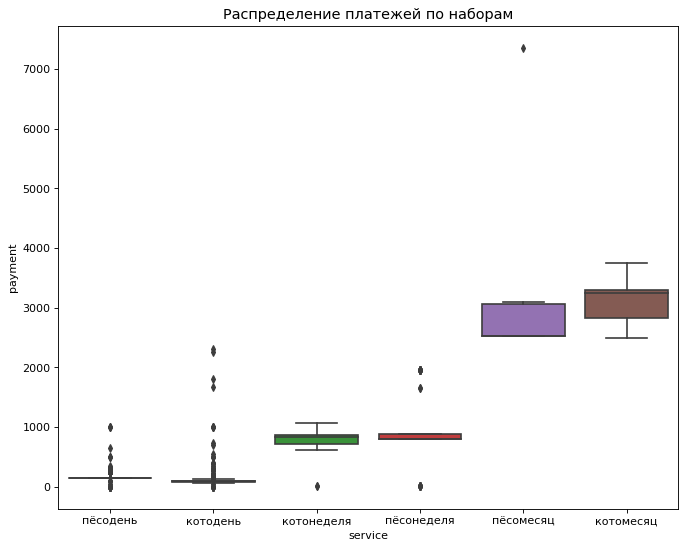

In [15]:
# посмотрим на график распределения Кото/Песо наборов

plt.figure(figsize=(10,8), dpi= 80)
sns.boxplot(x="service", y="payment", data=df[filter_sets])
plt.title('Распределение платежей по наборам', fontsize=13)
plt.show()

По графику видно, что есть выбросы по размеру платежей, как в меньшую, так и в большую сторону. 

Нам известно, что:

- платежи по наборам - это только фиксированные суммы
- цены на наборы устанавливаются отдельно для каждого приюта
- часть оплат за наборы реализована в долларах (объясняет "выбросы" в меньшую сторону)
- некоторые платежи были проведены сразу по нескольким позициям, но в данных представлены, как оплата за набор (это "выбросы" в большую сторону)

Исходя из перечисленных фактов необходимо:

- избавиться от "выбросов", чтобы они не влияли на формирование цены
- обрабатывать выбросы нужно отдельно в рамках каждого набора и приюта

Очищать данные от "выбросов" будем путем отсечения данных в соответствии с распределением размера платежей (по 5-му и 95-му процентилю).

Пограничные значения для отсечения необходимо определить для каждого набора и приюта отдельно, так как ценовая политика приютов отличается. Например, "средний" платеж за КотоДень в одном из приютов, может оказаться "выбросом" для другого.

**Удаление записей с выбросами**

Отдельно для каждого набора и для каждого приюта, продающего данный набор определим данные с "выбросами", установив флаг в поле-признаке "outlier":

- "0" - запись подходит для исследования цены набора
- "1" - "выброс"

In [16]:
# определим границы "выбросов" по 5му и 95му перцинтелю для каждой услуги в каждом приюте

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

payment_percentiles = df.groupby(['shelter', 'service']).agg({'payment': [percentile(5), percentile(95)]}).reset_index()
payment_percentiles.columns = ['shelter', 'service', 'percentile_5', 'percentile_95']
df = df.merge(payment_percentiles, on=['shelter','service'])

In [17]:
# установим флаг "выброса" только для наборов, в других услугах могут быть платежи произвольного размера

df['outlier'] = 0

filter_sets = df.service.str.endswith(('день', 'неделя', 'месяц'))
filtered_data = ((df['payment']<df['percentile_5'])|(df['payment']>df['percentile_95']))

df.loc[((filter_sets)&filtered_data), 'outlier'] = 1

In [18]:
# дата сет только по продаже наборов
df_sets = df[filter_sets].copy()
df_sets.head()

,userid,shelter,dt,service,payment,date,month,percentile_5,percentile_95,outlier
0,27542,Кот и Пёс,2019-09-01 01:02:25,пёсодень,155.0,2019-09-01,9,155.0,155.0,0
1,23484,Кот и Пёс,2019-09-01 15:52:02,пёсодень,155.0,2019-09-01,9,155.0,155.0,0
2,6370,Кот и Пёс,2019-09-01 20:21:47,пёсодень,155.0,2019-09-01,9,155.0,155.0,0
3,27763,Кот и Пёс,2019-09-01 23:12:23,пёсодень,155.0,2019-09-01,9,155.0,155.0,0
4,5976,Кот и Пёс,2019-09-02 16:08:58,пёсодень,155.0,2019-09-02,9,155.0,155.0,0


In [19]:
# какое количество выбросов "удалили" из данных

df['outlier'].value_counts()

0    13176
1      142
Name: outlier, dtype: int64

"Выбросы" определяем только для наборов. Для других услуг пожертвование может быть произвольного размера, поэтому нет оснований считать тот или иной платеж выбросом.

In [20]:
# число "выбросов" в срезе данных по наборам

df_sets['outlier'].value_counts()

0    6552
1     142
Name: outlier, dtype: int64

Выбросы по наборам составили около 2% от всех данных среза по наборам. 

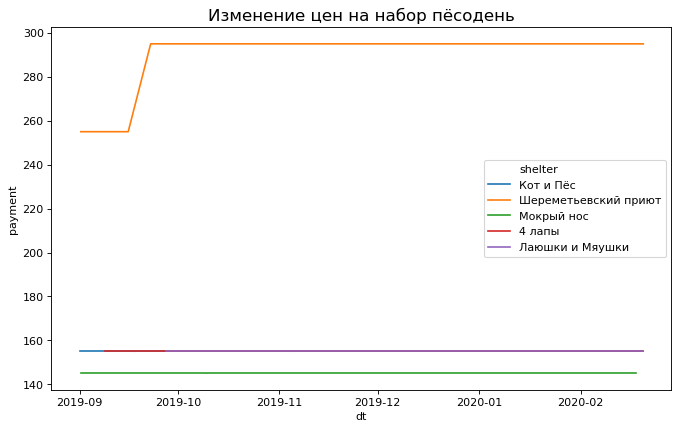

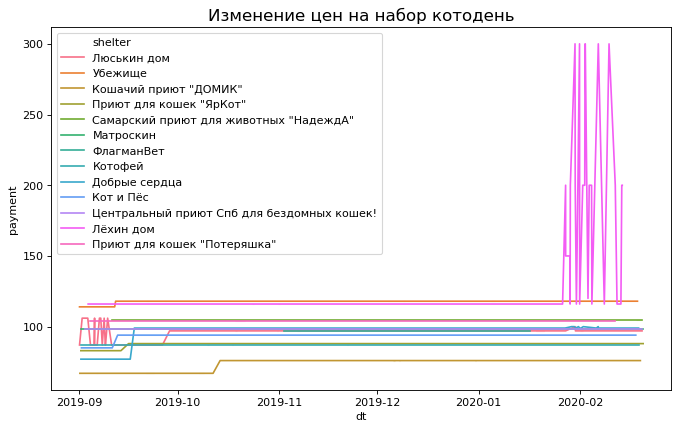

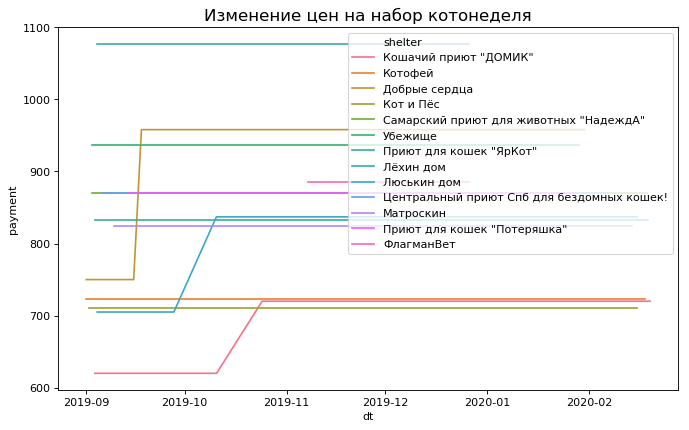

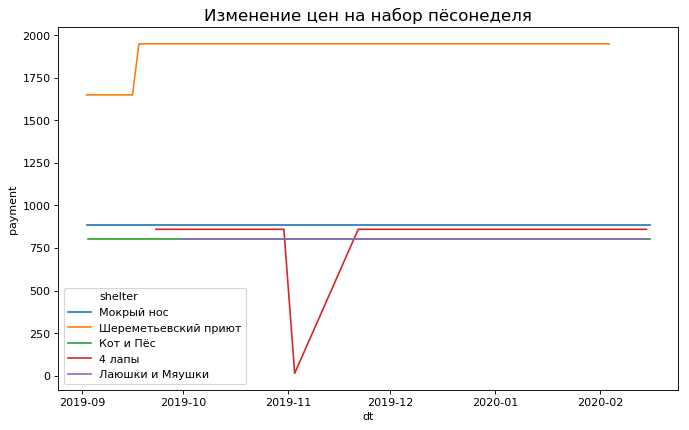

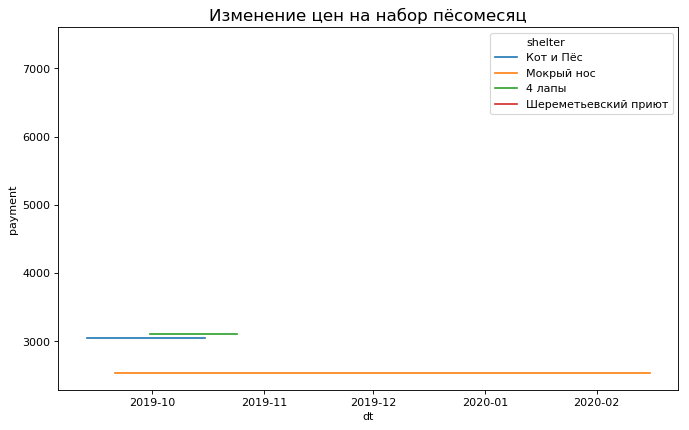

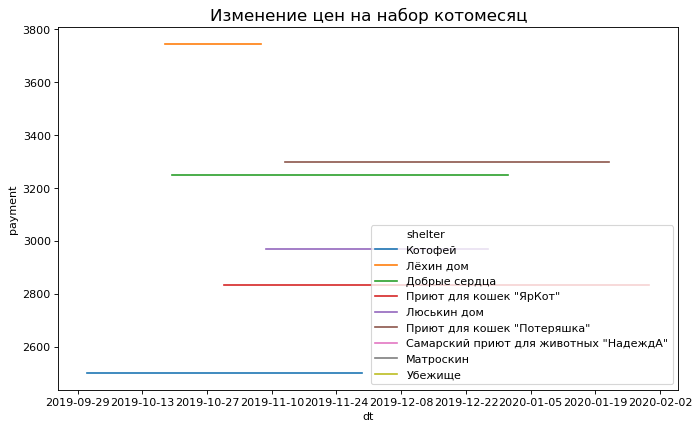

In [21]:
# построим графики Колебания цен Кото и Песо наборов по очищенным от "выбросов" данных на предыдущем шаге 

for payset in (list(df_sets['service'].unique())):
    plt.figure(figsize=(10,6), dpi= 80)
    sns.lineplot(x="dt", y="payment", hue="shelter", data=df_sets.query('(outlier == 0)&(service==@payset)'))
    plt.title('Изменение цен на набор '+payset, fontsize=15)
    plt.show()

По графикам увидели, где остались после очистки данных от "выбросов" "подозрительные" колебания.

Необходимо дополнительно изучить распределение платежей по набору КотоДень в приюте "Лёхин дом" и набора КотоНеделя в приюте "4 лапы" 

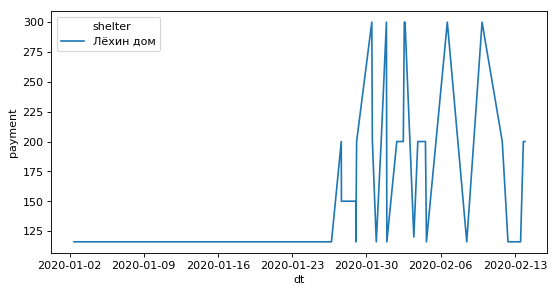

In [22]:
# построим график изменения цен КотоДней в приюте "Лёхин дом" с января 2020

plt.figure(figsize=(8,4), dpi= 80)
sns.lineplot(x="dt", y="payment", hue="shelter", 
             data=df_sets.query('(outlier == 0)&(service=="котодень")&(shelter=="Лёхин дом")&(dt>"2020-01-01")'));

In [23]:
# посмотрим числовое описание распределения

df_sets.query('(outlier == 0)&(service=="котодень")&(shelter=="Лёхин дом")&(dt>"2020-01-01")')['payment'].describe()

count     52.000000
mean     158.000000
std       62.372694
min      116.000000
25%      116.000000
50%      116.000000
75%      200.000000
max      300.000000
Name: payment, dtype: float64

In [24]:
# посмотрим, сколько значений выбиваются

df_sets.query('(outlier == 0)&(service=="котодень")&(shelter=="Лёхин дом")&(dt>"2020-01-01")')['payment'].value_counts()

116.0    31
200.0    12
300.0     6
150.0     2
120.0     1
Name: payment, dtype: int64

Судя по колебаниям цены на набор в конце января, начале февраля, складывается впечатление, что приют проводил эксперимент по изменению цены на набор, часть пользователей оплатили КотоДень по старой цене 116р, а часть по измененной цене в размере 200-300.

In [25]:
# посмотрим срез данных в период колебания цен

df_sets.query('(outlier == 0)&(service=="котодень")&(shelter=="Лёхин дом")&(dt>"2020-01-27")').head()

,userid,shelter,dt,service,payment,date,month,percentile_5,percentile_95,outlier
8126,28179,Лёхин дом,2020-01-27 14:56:28,котодень,200.0,2020-01-27,1,116.0,300.0,0
8127,29026,Лёхин дом,2020-01-27 15:18:48,котодень,150.0,2020-01-27,1,116.0,300.0,0
8130,29057,Лёхин дом,2020-01-28 23:50:34,котодень,150.0,2020-01-28,1,116.0,300.0,0
8131,22120,Лёхин дом,2020-01-28 23:55:31,котодень,116.0,2020-01-28,1,116.0,300.0,0
8132,25958,Лёхин дом,2020-01-29 01:41:56,котодень,200.0,2020-01-29,1,116.0,300.0,0


"Выбросами" эти значения считать не можем, ограниченный набор изменяющихся цен указывает, на установление приютом экспериментальной стоимости за набор.

Проверим "выброс" в платежах по ПёсоНеделям приюта 4 лапы:

In [26]:
df_sets.query('(outlier == 0)&(service=="пёсонеделя")&(shelter=="4 лапы")')['payment'].value_counts()

860.00    18
13.44      1
Name: payment, dtype: int64

Один платеж прошел в валюте. Все остальные платежи сделаны в сумме 860р, так как других вариантов цен на ПёсоНеделю в приюте "4 лапы" нет, то можем заменить выбивающееся значение на установленную цену за недельный набор в рублях "в лоб".

In [27]:
# заменим выбивающееся значение на медианное

median = df_sets.query('(outlier == 0)&(service=="пёсонеделя")&(shelter=="4 лапы")')['payment'].median()
filtered = (df['outlier'] == 0)&(df['service']=="пёсонеделя")&(df['shelter']=="4 лапы")

df.loc[filtered, 'payment'] = median
df_sets = df[filter_sets].copy()

**Выводы:**

Очистили данные от "выбросов", изучили изменение цен за предоставленный период выгруженных данных о платежах.

- Самые стабильные цены на наборы Кото и Песо Месяцев, не зафиксировано никаких изменений цен
- Кото/ПесоНедли и Кото/ПесоДни имеют схожую тенденцию по приютам - стартовые цены осенью были ниже, после опробации цены были откорректированы в большую сторону.
- В целом все цены на наборы стабильны, за исключением одного приюта "Лёхин дом", в котором проводились эксперименты по ценовым вариациям на КотоДни.

<a id="users"></a>
### Характеристики пользователей

Посчитаем описательные метрики пользователей на основе информации о тратах в сервисе.

In [28]:
# посмотрим на данные
df.head()

,userid,shelter,dt,service,payment,date,month,percentile_5,percentile_95,outlier
0,27542,Кот и Пёс,2019-09-01 01:02:25,пёсодень,155.0,2019-09-01,9,155.0,155.0,0
1,23484,Кот и Пёс,2019-09-01 15:52:02,пёсодень,155.0,2019-09-01,9,155.0,155.0,0
2,6370,Кот и Пёс,2019-09-01 20:21:47,пёсодень,155.0,2019-09-01,9,155.0,155.0,0
3,27763,Кот и Пёс,2019-09-01 23:12:23,пёсодень,155.0,2019-09-01,9,155.0,155.0,0
4,5976,Кот и Пёс,2019-09-02 16:08:58,пёсодень,155.0,2019-09-02,9,155.0,155.0,0


In [29]:
users = df.groupby('userid').agg({'dt':['min','max','count'], 'date':'nunique',
                                  'payment':['sum','mean','max'], 'service':'nunique'})
users = users.reset_index()

In [30]:
# переименуем столбцы: время первой транзакции / время последней транзакции / число транзакций / 
# число дней, в которые были совершены покупки / суммарные траты / 
# / средний чек / максимальная сумма в одном платеже / число уникальных услуг, приобретенных пользователем 

users.columns = ['userid','first_entry', 'last_entry', 'transact_count', 'activity_days', 'expenses', 'average_bill', 'max_bill', 'sets_count']
users.head()

,userid,first_entry,last_entry,transact_count,activity_days,expenses,average_bill,max_bill,sets_count
0,24,2019-09-06 14:47:50,2019-12-09 18:57:18,7,6,195.0,27.857143,75.0,2
1,82,2019-09-16 11:38:52,2019-09-16 11:41:09,2,1,214.0,107.000000,116.0,1
2,88,2020-01-22 00:36:34,2020-01-22 00:40:09,2,1,245.0,122.500000,145.0,2
3,95,2019-09-12 17:25:09,2019-09-12 17:27:15,2,1,194.0,97.000000,100.0,2
4,102,2020-02-08 10:56:17,2020-02-08 10:56:17,53,1,5704.0,107.622642,295.0,20


**Платежеспособность пользователя**

Мы уже посчитали средний чек по транзакции. Но одна транзакция чаще всего содержит покупку одной услуги и характеризует выбор услуг пользователем по их номинальной цене.

Но нам также интересно, сколько готов потратить денег пользователь не только за 1 транзакцию, но и за один день активности в сервисе, это может быть одна покупка нескольких услуг или череда взносов нескольким питомцам подряд за один день.

Назовем этот показатель платежеспособностью solvency и посчитаем его, как отношение общей суммы, которую он потратил в сервисе на число дней активности в сервисе.

In [31]:
users['solvency'] = users['expenses']/users['activity_days']
users.head()

,userid,first_entry,last_entry,transact_count,activity_days,expenses,average_bill,max_bill,sets_count,solvency
0,24,2019-09-06 14:47:50,2019-12-09 18:57:18,7,6,195.0,27.857143,75.0,2,32.5
1,82,2019-09-16 11:38:52,2019-09-16 11:41:09,2,1,214.0,107.000000,116.0,1,214.0
2,88,2020-01-22 00:36:34,2020-01-22 00:40:09,2,1,245.0,122.500000,145.0,2,245.0
3,95,2019-09-12 17:25:09,2019-09-12 17:27:15,2,1,194.0,97.000000,100.0,2,194.0
4,102,2020-02-08 10:56:17,2020-02-08 10:56:17,53,1,5704.0,107.622642,295.0,20,5704.0


**Сколько пользователь тратил в месяц**

In [32]:
users_month_expenses = df.groupby(['userid','month'])['payment'].sum().reset_index()
users_month_expenses.head()

,userid,month,payment
0,24,9,20.0
1,24,11,80.0
2,24,12,95.0
3,82,9,214.0
4,88,1,245.0


In [33]:
# Посчитаем медианное значение по ежемесячным тратам каждого пользователя

users_month_expenses = users_month_expenses.groupby('userid')['payment'].median().reset_index().rename(columns={'payment':'month_expenses'})

In [34]:
# присоединим показатель ежемесячных трат по пользователям в таблицу характеристик

users = users.merge(users_month_expenses, on='userid')

In [35]:
users.head()

,userid,first_entry,last_entry,transact_count,activity_days,expenses,average_bill,max_bill,sets_count,solvency,month_expenses
0,24,2019-09-06 14:47:50,2019-12-09 18:57:18,7,6,195.0,27.857143,75.0,2,32.5,80.0
1,82,2019-09-16 11:38:52,2019-09-16 11:41:09,2,1,214.0,107.000000,116.0,1,214.0,214.0
2,88,2020-01-22 00:36:34,2020-01-22 00:40:09,2,1,245.0,122.500000,145.0,2,245.0,245.0
3,95,2019-09-12 17:25:09,2019-09-12 17:27:15,2,1,194.0,97.000000,100.0,2,194.0,194.0
4,102,2020-02-08 10:56:17,2020-02-08 10:56:17,53,1,5704.0,107.622642,295.0,20,5704.0,5704.0


Так как нас для дальнейшей модели ценообразования нас интересуют покупатели наборов, то распределение среднемесячных платежей посмотрим по выборке только этих пользователей.

In [36]:
users_sets = df_sets[df_sets['outlier']==0]['userid'].unique()
users_month_expenses[users_month_expenses['userid'].isin(list(users_sets))]['month_expenses'].describe()

count     1342.000000
mean       797.558107
std       1335.064360
min         58.500000
25%        184.000000
50%        380.750000
75%        869.000000
max      20144.000000
Name: month_expenses, dtype: float64

Категории пользователей по размеру платежей разделим на 4 группы:

- (1) до 150р 
- (2) 150 - 400р
- (3) 400 - 900р
- (4) больше 900р 

In [37]:
def month_expenses_category(row):
    if row['month_expenses'] < 150:
        return 1
    elif (row['month_expenses'] >= 150)&(row['month_expenses'] < 500): 
        return 2
    elif (row['month_expenses'] >= 500)&(row['month_expenses'] < 1000): 
        return 3
    else:
        return 4

users['expenses_cat'] = users.apply(lambda row: month_expenses_category(row), axis=1) 

users.head()

,userid,first_entry,last_entry,transact_count,activity_days,expenses,average_bill,max_bill,sets_count,solvency,month_expenses,expenses_cat
0,24,2019-09-06 14:47:50,2019-12-09 18:57:18,7,6,195.0,27.857143,75.0,2,32.5,80.0,1
1,82,2019-09-16 11:38:52,2019-09-16 11:41:09,2,1,214.0,107.000000,116.0,1,214.0,214.0,2
2,88,2020-01-22 00:36:34,2020-01-22 00:40:09,2,1,245.0,122.500000,145.0,2,245.0,245.0,2
3,95,2019-09-12 17:25:09,2019-09-12 17:27:15,2,1,194.0,97.000000,100.0,2,194.0,194.0,2
4,102,2020-02-08 10:56:17,2020-02-08 10:56:17,53,1,5704.0,107.622642,295.0,20,5704.0,5704.0,4


**Консервативность покупателя**

Определим показатель, который показывает, насколько пользователь консервативен или наоборот готов экспериментировать с покупкой разных услуг.

set_count - показывает сколько разных наименований услуг приобретал пользователь.

In [38]:
users['sets_count'].describe()

count    1660.000000
mean        3.403012
std         3.317932
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        31.000000
Name: sets_count, dtype: float64

Бинарное значение "консервативности" устанавливаем, исходя из распределения значений: покупал меньше 2х разных услуг - консерватор (1), 2 и больше - нет (0)

In [39]:
users['conservative'] = np.where(users['sets_count']<2, 1, 0)

### Выручка по наборам в приютах <a id="revenue"></a>

Посчитаем показатели в разрезе приюта и типа набора:

- объем выручки за весь период
- количество приобретенных наборов
- сренюю цену за каждый набор
- число уникальных пользователей, приобретавших набор

In [40]:
# количество покупок / выручка по наборам / средняя цена набора / число уникальных пользователей

revenue = df_sets[df_sets['outlier']==0].groupby(['shelter','service']).agg({'payment':['count','sum', 'mean'], 'userid':'nunique'})
revenue

payment           \
                                                        count      sum   
shelter                                    service                       
4 лапы                                     пёсодень       206  31930.0   
                                           пёсомесяц        2   6200.0   
                                           пёсонеделя      19  16340.0   
Добрые сердца                              котодень       310  29837.0   
                                           котомесяц        2   6498.0   
                                           котонеделя      28  25992.0   
Кот и Пёс                                  котодень       161  15053.0   
                                           котонеделя      27  19170.0   
                                           пёсодень       264  40920.0   
                                           пёсомесяц        2   6100.0   
                                           пёсонеделя      43  34400.0   
Котофей                                    котодень       581  50547.0   
                                           котомесяц        3   7500.0   
                                           котонеделя      54  39042.0   
Кошачий приют "ДОМИК"                      котодень       574  42490.0   
                                           котонеделя      52  35740.0   
Лаюшки и Мяушки                            пёсодень       307  47585.0   
                                           пёсонеделя      42  33600.0   
Люськин дом                                котодень       412  39690.0   
                                           котомесяц        2   5936.0   
                                           котонеделя      52  42996.0   
Лёхин дом                                  котодень       289  35708.0   
                                           котомесяц        2   7490.0   
                                           котонеделя      11  11847.0   
Матроскин                                  котодень       230  22540.0   
                                           котомесяц        1   3280.0   
                                           котонеделя      24  19800.0   
Мокрый нос                                 пёсодень       576  83520.0   
                                           пёсомесяц        7  17710.0   
                                           пёсонеделя      58  51446.0   
Приют для кошек "Потеряшка"                котодень       265  27560.0   
                                           котомесяц        4  13200.0   
                                           котонеделя      18  15660.0   
Приют для кошек "ЯрКот"                    котодень       366  31943.0   
                                           котомесяц        3   8505.0   
                                           котонеделя      31  25792.0   
Самарский приют для животных "НадеждА"     котодень       529  55545.0   
                                           котомесяц        1   3300.0   
                                           котонеделя      53  46110.0   
Убежище                                    котодень       432  50688.0   
                                           котомесяц        1   3373.0   
                                           котонеделя      24  22488.0   
ФлагманВет                                 котодень        26   2522.0   
                                           котонеделя       4   3544.0   
Центральный приют Спб для бездомных кошек! котодень       286  28028.0   
                                           котонеделя      21  18270.0   
Шереметьевский приют                       пёсодень       132  37820.0   
                                           пёсомесяц        1   7360.0   
                                           пёсонеделя      14  26700.0   

                                                                    userid  
                                                              mean nunique  
shelter                                    service 

In [41]:
revenue = revenue.reset_index()

In [42]:
# переименуем 2хуровневые названия колонок

revenue.columns = ['shelter', 'service', 'count', 'sum', 'mean', 'user_count']

**Рассчитаем дополнительно метрики:**

- Цену одного дня в каждом наборе по формуле: средняя цена набора / на номинальное число дней. Например, номинал для КотоДня - 1 день, для КотоНедели - 7 дней, для КотоМесяца соответственно - 30 дней.
- Сколько в рублях в среднем тратит один пользователь на набор в приюте
- Среднее число транзакций по покупке пакетов на 1 пользователя

In [43]:
# сколько стоит 1 "КотоДень" или 1 "Песодень" в каждом наборе

month_service = ['котомесяц','пёсомесяц'] 
week_service = ['котонеделя', 'пёсонеделя']

# определим стоимость каждого набора в пересчете на 1 день
revenue['dayprice'] = np.where(revenue['service'].isin(month_service), revenue['mean']/30, 
                          np.where(revenue['service'].isin(week_service), revenue['mean']/7, revenue['mean']))

# средний доход с одного клиента по набору
revenue['setARPU'] = revenue['sum']/revenue['user_count']

# среднее число транзаций (назавем TPU transaction per user)
revenue['TPU'] = revenue['count']/revenue['user_count']

revenue.head(10)

,shelter,service,count,sum,mean,user_count,dayprice,setARPU,TPU
0,4 лапы,пёсодень,206,31930.0,155.000000,140,155.000000,228.071429,1.471429
1,4 лапы,пёсомесяц,2,6200.0,3100.000000,2,103.333333,3100.000000,1.000000
2,4 лапы,пёсонеделя,19,16340.0,860.000000,15,122.857143,1089.333333,1.266667
3,Добрые сердца,котодень,310,29837.0,96.248387,161,96.248387,185.322981,1.925466
4,Добрые сердца,котомесяц,2,6498.0,3249.000000,2,108.300000,3249.000000,1.000000
5,Добрые сердца,котонеделя,28,25992.0,928.285714,21,132.612245,1237.714286,1.333333
6,Кот и Пёс,котодень,161,15053.0,93.496894,97,93.496894,155.185567,1.659794
7,Кот и Пёс,котонеделя,27,19170.0,710.000000,14,101.428571,1369.285714,1.928571
8,Кот и Пёс,пёсодень,264,40920.0,155.000000,158,155.000000,258.987342,1.670886
9,Кот и Пёс,пёсомесяц,2,6100.0,3050.000000,2,101.666667,3050.000000,1.000000


Оказалось, что стоимость наборов на Неделю или Месяц в пересчете на 1 день в некоторых приютах обходится пользователям дороже, чем покупка 1 Кото/ПесоДня. Не смотря на то, что в недельный набор кроме основного ухода (кормление + наполнение туалета (для кошек)) входит реклама питомца в социальных сетях, при завышенной цене в пересчете на один день, значительная часть пользователей выбирает покупку одного дня с самым необходимым.

Для удобства визуальной оценки данных по ценам установим категориальные значения на поле с наименование набора. Это позволит вывести графики цены за один день в едином стиле и с заданной последовательностью: Кото/ПесоДень-Неделя-Месяц. 

In [44]:
# Установим категориальные значения для наборов
revenue['service'] = pd.Categorical(revenue['service'],
                                    ["котодень", "котонеделя", "котомесяц", "пёсодень", "пёсонеделя", "пёсомесяц"])

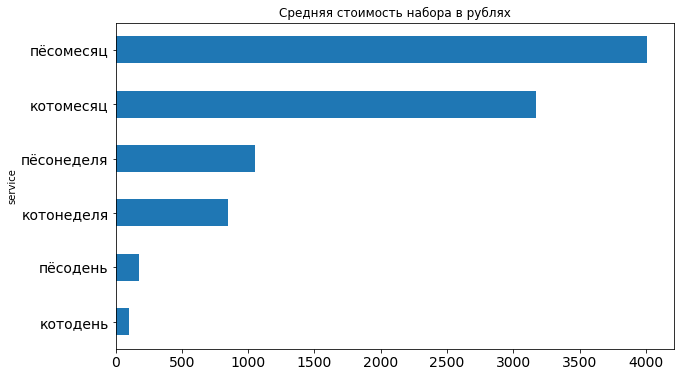

In [45]:
# график средней стоимости каждого набора по всем приютам

revenue.groupby('service')['mean'].mean().sort_values().plot(fontsize='14', title='Средняя стоимость набора в рублях',
                                                                              kind='barh', figsize=(10,6));

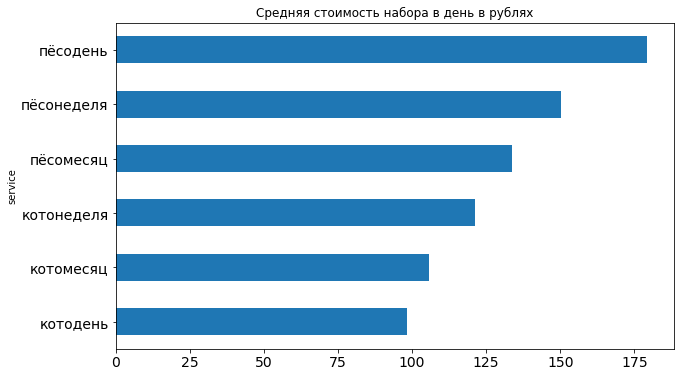

In [46]:
# график средней стоимости каждого набора в дневном эквиваленте

revenue.groupby('service')['dayprice'].mean().sort_values().plot(fontsize='14', title='Средняя стоимость набора в день в рублях',
                                                                              kind='barh', figsize=(10,6));

Построим графики распределению выручки по наборам у каждого приюта, а также рядом выведем графики цены набора в пересчете на 1 день.

Суммарная выручка и цена 1 Дня в приюте "Кот и Пёс"


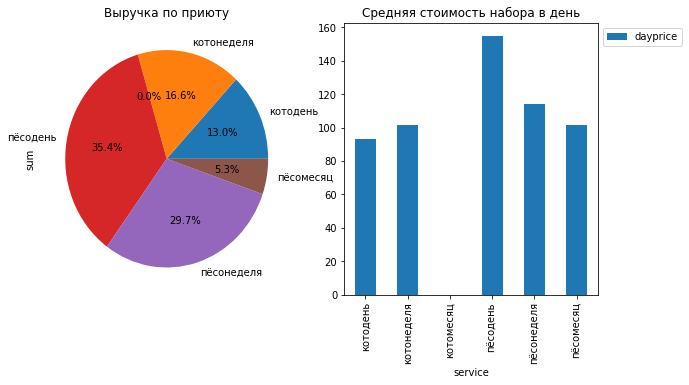

Суммарная выручка и цена 1 Дня в приюте "Люськин дом"


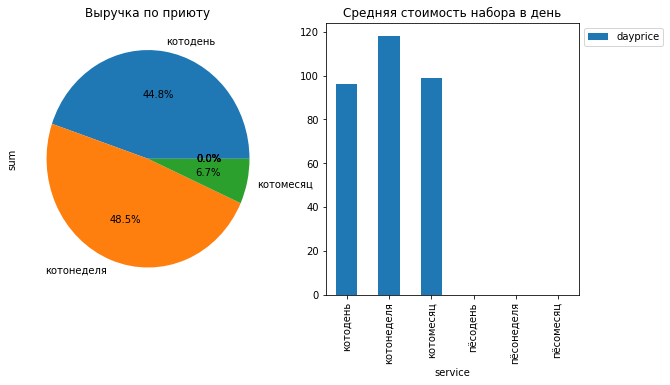

Суммарная выручка и цена 1 Дня в приюте "Убежище"


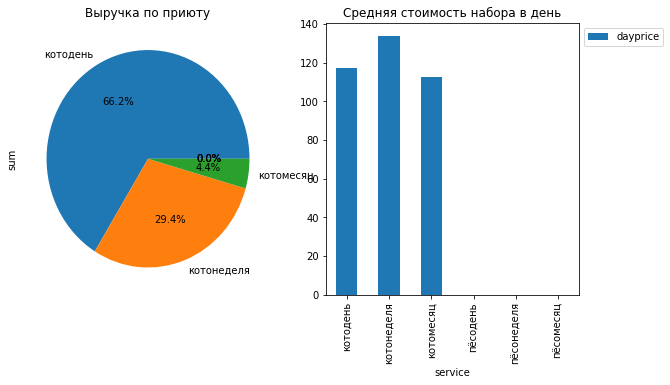

Суммарная выручка и цена 1 Дня в приюте "Кошачий приют "ДОМИК""


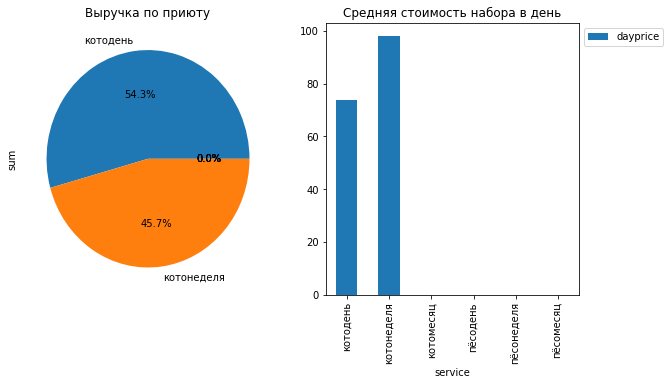

Суммарная выручка и цена 1 Дня в приюте "Котофей"


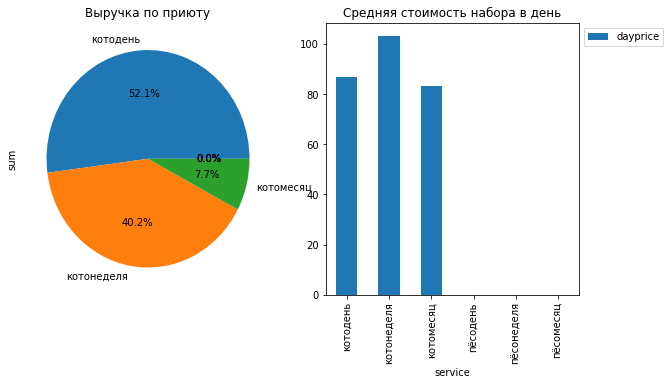

Суммарная выручка и цена 1 Дня в приюте "Добрые сердца"


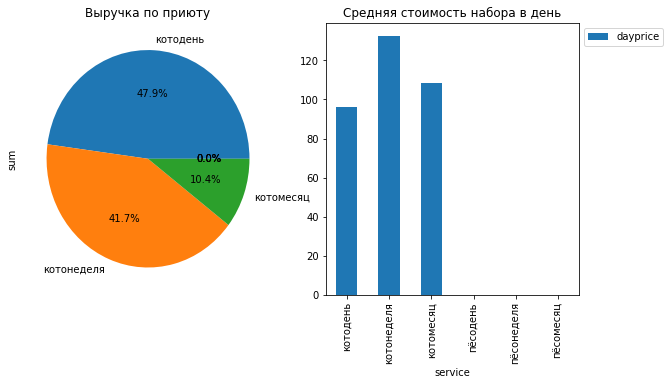

Суммарная выручка и цена 1 Дня в приюте "Шереметьевский приют"


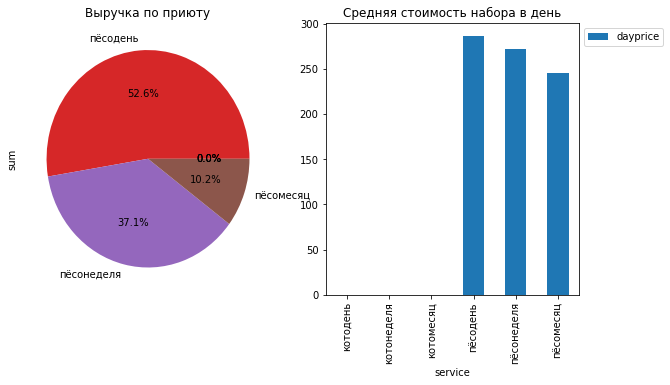

Суммарная выручка и цена 1 Дня в приюте "Приют для кошек "ЯрКот""


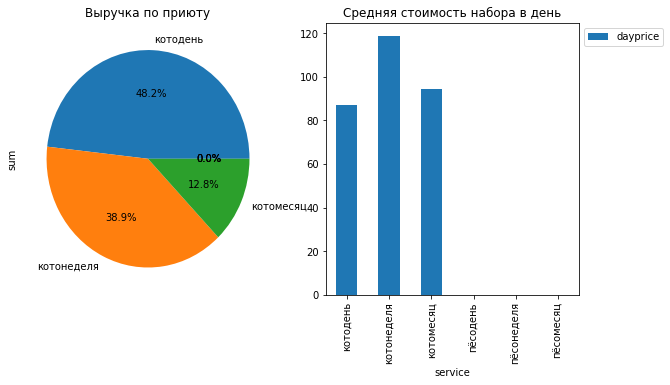

Суммарная выручка и цена 1 Дня в приюте "Самарский приют для животных "НадеждА""


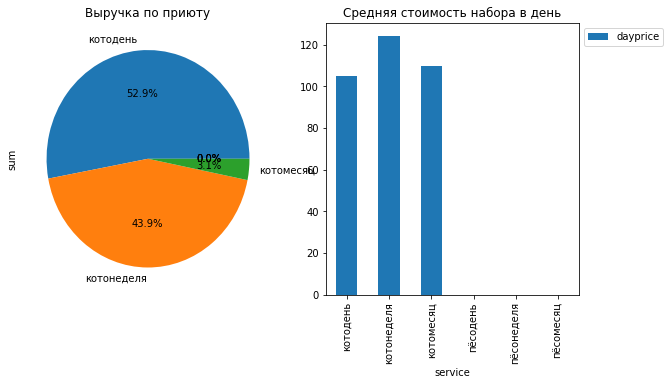

Суммарная выручка и цена 1 Дня в приюте "Матроскин"


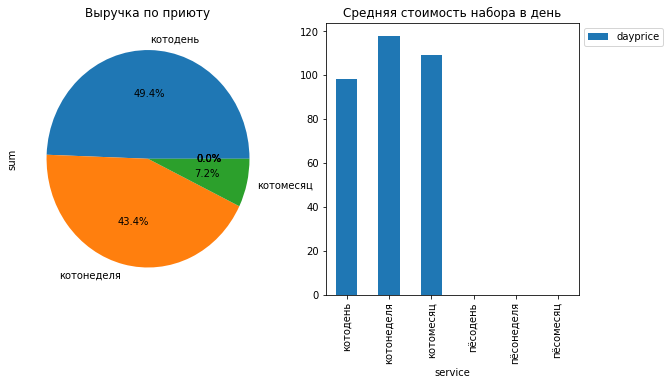

Суммарная выручка и цена 1 Дня в приюте "ФлагманВет"


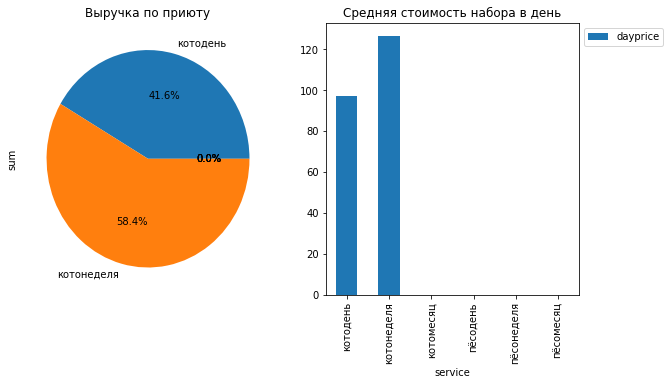

Суммарная выручка и цена 1 Дня в приюте "Мокрый нос"


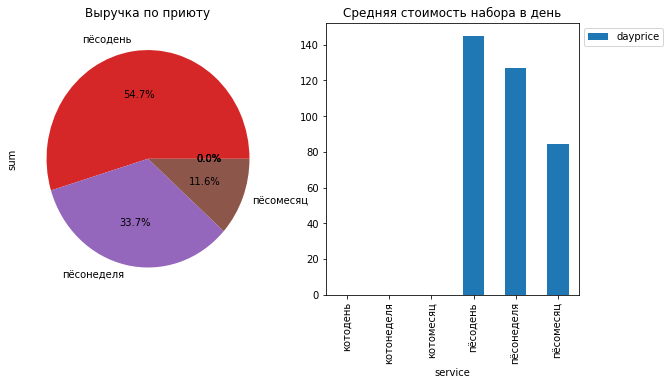

Суммарная выручка и цена 1 Дня в приюте "Центральный приют Спб для бездомных кошек!"


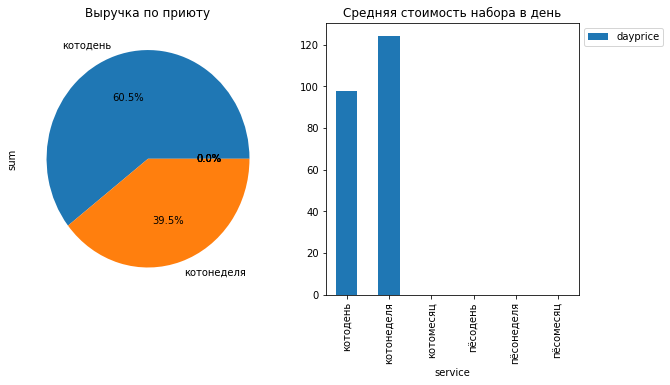

Суммарная выручка и цена 1 Дня в приюте "Лёхин дом"


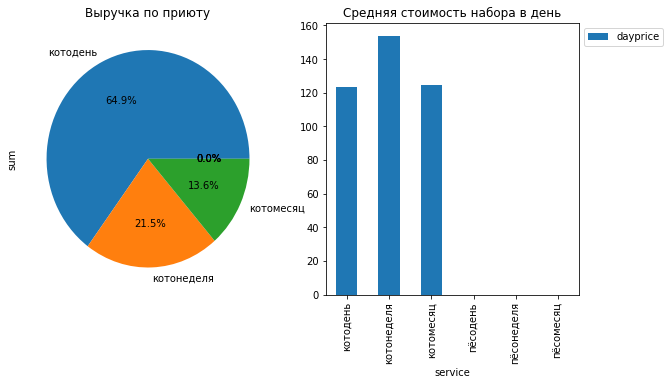

Суммарная выручка и цена 1 Дня в приюте "Приют для кошек "Потеряшка""


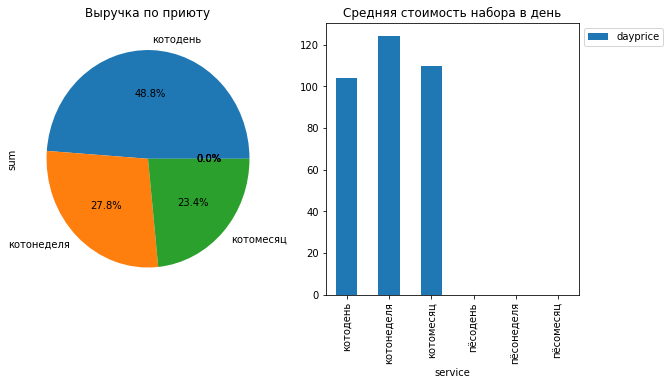

Суммарная выручка и цена 1 Дня в приюте "4 лапы"


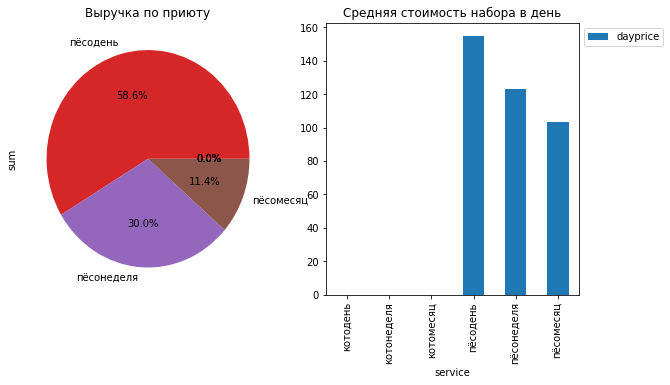

Суммарная выручка и цена 1 Дня в приюте "Лаюшки и Мяушки"


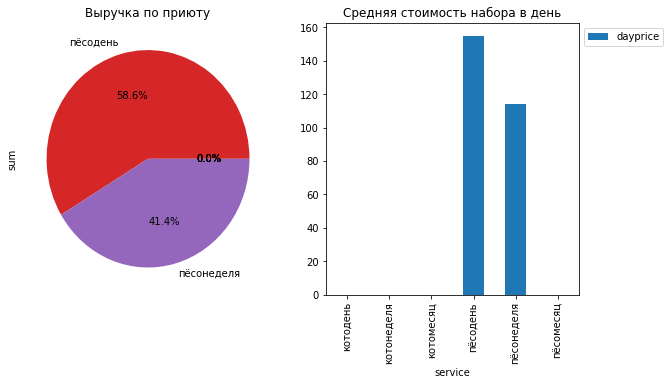

In [47]:
shelters = df_sets['shelter'].unique()

for shelter in list(shelters):
    print('Суммарная выручка и цена 1 Дня в приюте "'+shelter+'"')
    plt.subplot(1,2,1)
    revenue[revenue['shelter']==shelter].groupby('service')['sum'].sum().plot(title='Выручка по приюту',kind='pie', autopct='%1.1f%%')
    
    plt.subplot(1,2,2)
    revenue[revenue['shelter']==shelter].groupby('service')['dayprice'].sum().plot(title='Средняя стоимость набора в день', 
                                                                              kind='bar', figsize=(10,5))
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    
    plt.show()

Посмотрим на самые успешные кейсы. Найдем приюты, в которых наибольшая средняя выручка в пересчете на одну транзакцию. Из-за особенностей ценообразования будем считать отдельно по КотоНаборам и Песонаборам.

In [48]:
# ПесоНаборы

top_dog_shelters = revenue[revenue.service.str.startswith('пёсо')].groupby('shelter').agg({'sum':'sum','count':'sum'}).reset_index()
top_dog_shelters['revenue_per_transaction']=top_dog_shelters['sum']/top_dog_shelters['count']
top_dog_shelters.sort_values('revenue_per_transaction', ascending=False)

,shelter,sum,count,revenue_per_transaction
4,Шереметьевский приют,71880.0,147,488.979592
1,Кот и Пёс,81420.0,309,263.495146
0,4 лапы,54470.0,227,239.955947
3,Мокрый нос,152676.0,641,238.184087
2,Лаюшки и Мяушки,81185.0,349,232.621777


Абсолютный лидер по выручке на одну транзакцию - Шереметьевский приют. Не смотря на самые высокие цены в сравнении с другими приютами, в нем наблюдается и самая высокая покупательская активность пользователей.

In [49]:
# КотоНаборы

top_cat_shelters = revenue[revenue.service.str.startswith('кото')].groupby('shelter').agg({'sum':'sum','count':'sum'}).reset_index()
top_cat_shelters['revenue_per_transaction']=top_cat_shelters['sum']/top_cat_shelters['count']
top_cat_shelters.sort_values('revenue_per_transaction', ascending=False)

,shelter,sum,count,revenue_per_transaction
11,ФлагманВет,6066.0,30,202.200000
7,"Приют для кошек ""Потеряшка""",56420.0,287,196.585366
4,Люськин дом,88622.0,466,190.175966
0,Добрые сердца,62327.0,340,183.314706
5,Лёхин дом,55045.0,302,182.268212
1,Кот и Пёс,34223.0,188,182.037234
9,"Самарский приют для животных ""НадеждА""",104955.0,583,180.025729
6,Матроскин,45620.0,255,178.901961
10,Убежище,76549.0,457,167.503282
8,"Приют для кошек ""ЯрКот""",66240.0,400,165.600000


По Котонаборам лидер по средней выручке на 1 транзакцию стал приют ФлагманВет, но на него не будем ориентироваться, так как в нем пока очень мало накопленных данных - всего 30 транзакций.

**Топ приютов со сбалансированной ценовой политикой на Котонаборы:**

- Приют для кошек "Потеряшка"
- Люськин дом
- Добрые сердца

Найдем среднее число транзакций на одного пользователя в разрезе наборов.

In [50]:
revenue.groupby('service')['TPU'].mean()

service
котодень      1.818150
котонеделя    1.407537
котомесяц     1.388889
пёсодень      1.603007
пёсонеделя    1.446175
пёсомесяц     1.100000
Name: TPU, dtype: float64

**Выводы:**

Изучив графики по составу "выручки" по каждому приюту, увидели, что наибольший вклад в выручку в большинстве приютов вносит продажа Кото/ПесоДня. На втором месте по доли выручки - пакет Кото/ПесоНеделя, у 80% приютов доля выручки по нему превышает 30%.

А в приютах "Кот и Пес", "Люскин дом" и "ФлагманВет" набор КотоНеделя принес больше выручки, чем набор КотоДень.

**Реклама кошек в социальных сетях дороже рекламы собак?**

По графикам увидели интересную тенденцию:

- КотоДень во всех приютах дешевле, чем КотоНеделя в пересчете на 1 день.
- ПесоДень во всех приютах дороже ПесоНедели в пересчете на стоимость 1 дня.

И у кошек, и у собак различие между однодневным и многодневным набором заключается только в количестве дней и в наличии рекламных ротаций для питомца.

<a id="modeling"></a>
## Моделирование оптимальной цены

Проанализировав данные по выручке, пришли к нескольким выводам:

**Наиболее популярны наборы на 1 день**

Причин этого может быть несколько:

- Новички в сервисе выбирают самый дешевый набор для знакомства с системой.
- Человеку проще расстаться с небольшой суммой, которая незначительно отразится на тратах в его бюджете.
- Считают цену на однодневный набор выгодной. В то время, как покупка "Недельного" и "Месячного" набора на ту же сумму будет относится только к одному питомцу. Это подтверждается числом транзаций на одного пользователя.

**Несбалансированы цены на многодневные пакеты**

Основываясь на собранных данных, увидели, что цены на наборы в разных приютах "скачут" без системной градации по количеству дней в наборе. Например, в приютах Кошек при пересчете на 1 день набор за Неделю стоит дороже, чем  при покупке 1 Дня. Внимательные покупатели на это обращают внимание, даже если в многодневные наборы дополнительно входит реклама питомца в соц.сетях.

<a id="model"></a>
## Концепция ценообразования

**Делаем ставку на Недельные наборы**

По результатам исследования точкой роста для увеличения выручки приютов считаю продвижение наборов Кото/ПесоНедель. Как показал анализ собранных данных, однодневные пакеты супер-популярны и это подкреплено многими фактами. Месячные наборы непопулярны совсем, так как покупателей скорее всего останавливает большая сумма для единовременной покупки по данной статье расходов.

**Преимущества Недельных наборов:**

- Недельные наборы в 80% приютов приносят более 30% выручки, а в 3х из 17 даже опережают оборот по однодневным пакетам.
- Среднее количество транзакций на 1 пользователя в однодневных и недельных наборах отличается для Котонаборов на 22%, для Песонаборов всего на 9%. Поэтому если часть транзакций оплат за 1 день преобразуется в транзакцию за недельный набор, выручка вырастет.
- Приюту выгоднее получить единоразово большую сумму для оперативных расходов на будущие периоды.
- Удобно организовать мероприятия по "возврату" пользователя и повторную оплату. Например, пользователь купил набор на Неделю, спустя 7 дней можно отправить сообщение или рассылку о благодарности и информации о его любимом питомце и возможности провести повторный платеж по шаблону. Пользователям, приобретавшим однодневный пакет, тоже можно рассылать "возвращающие" сообщения, но слишком частая рассылка будет иметь обратный эффект. 

Важно отметить, что для реформирования ценообразования все варианты наборов, включая Месячный пакет должны быть представлены для выбора пользователей. Не смотря на то, что набор на месяц не оправдывает ожиданий по выручке, он служит "Якорем" для маркетингового продвижения более доступного по цене набора на Неделю.

**Методы продвижения Недельных наборов:**

- Сбалансировать цены на недельные наборы. Предположим, что уравнение цен в пересчете на 1 день однодневных и недельных наборов позволит увеличить оборот Недельных наборов и выручку.
- Отметить преимущества набора для пользователей в экономическом и эмоциональном плане.

**Экономическое обоснование покупки Недельного набора для пользователя**

Покупка такого набора должна обходиться пользователю не дороже, чем за 7 однодневных наборов, но при этом приятным бонусом будет то, что в набор входит реклама питомца в соц.сетях. Так как это приют для животных и менталитет российского обывателя не хочет знать о прибыли такого рода организации, то обязательно необходимо написать обоснование, почему вдруг недельный набор стоит дешевле в пересчете на день с учетом рекламных ротаций. Например, при большем обороте у приюта есть возможность закупать корм оптом, а если рассчитывать только на однодневные пожертвования, то не всегда это бывает возможным.

**Эмоциональное обоснование покупки многодневного пакета**

Большинство людей действительно в череде будничных забот не успевают думать о всех вещах, которые их волнуют. Покупка недельного набора должна принести пользователю спокойствие и чувство выполненного долга о заботе о любимом питомце. Посыл может быть сконцентрирован вокруг суеты рабочих дней и о том, что потратив минутку и немного средств в пятницу/в выходной день, Вы будете уверены, что приют не будет испытывать материальных сложностей при заботе о питомце, к тому же купив пакет с рекламой, вы повысите его шансы найти "семью".

**Ценовая политика:**

- Цена на однодневный набор должна быть эквивалентна стоимости недельного набору в пересчете на 1 день.
- Кото/ПесоМесяц выступает "Якорем" для обращения внимание на недельный набор, поэтому допускаем любую цену на эту услугу, концентрируя внимание на изменение цен Недельного набора.

Расчет прогнозной модели покажет состоятельность изменений цен на недельные и однодневные наборы.

**Допущения новой модели ценообразования**

- В предложенной модели считаем, что цена каждого набора продиктована затратами того или иного приюта и регулировать цену можем только методом наценки на однодневный или недельный набор.
- Пересчету цен подлежат однодневные или недельные пакеты, за счет повышения стоимости.
- Цену на месячные наборы оставляем неизменной. Напомню, набор на месяц является "Якорем" в нашей линейке пакетов услуг, его задача "подсвечивать" ценовое преимущество Недельного набора. Ставку на увеличение продаж месячного набора не делаем.

In [51]:
# прибыль по пользователям
revenue_per_user = df_sets[df_sets['outlier']==0].groupby(['shelter','service','userid']).agg({'payment':['count','sum', 'mean']})
revenue_per_user.head()

payment              
                          count    sum   mean
shelter service  userid                      
4 лапы  пёсодень 807          1  155.0  155.0
                 1510         1  155.0  155.0
                 1673         1  155.0  155.0
                 2100         1  155.0  155.0
                 2188         1  155.0  155.0

In [52]:
revenue_per_user = revenue_per_user.reset_index()

In [53]:
revenue_per_user.columns = ['shelter', 'service', 'userid', 'count', 'sum', 'mean_price']

In [54]:
# установим поле код набора, определяющий какой набор был приобретен в данной транзакции пользователем

sets_dict = {"котодень": 1, "пёсодень":1, "котонеделя": 7, "пёсонеделя": 7, "котомесяц": 30, "пёсомесяц": 30}

revenue_per_user['set_code'] = revenue_per_user['service'].map(sets_dict)

In [55]:
revenue_per_user.head(10)

,shelter,service,userid,count,sum,mean_price,set_code
0,4 лапы,пёсодень,807,1,155.0,155.0,1
1,4 лапы,пёсодень,1510,1,155.0,155.0,1
2,4 лапы,пёсодень,1673,1,155.0,155.0,1
3,4 лапы,пёсодень,2100,1,155.0,155.0,1
4,4 лапы,пёсодень,2188,1,155.0,155.0,1
5,4 лапы,пёсодень,2474,1,155.0,155.0,1
6,4 лапы,пёсодень,2488,1,155.0,155.0,1
7,4 лапы,пёсодень,2550,2,310.0,155.0,1
8,4 лапы,пёсодень,2824,1,155.0,155.0,1
9,4 лапы,пёсодень,3279,1,155.0,155.0,1


In [56]:
# добавим к таблице поля характеристик пользователей
user_sets = list(revenue_per_user['userid'].unique())

users_sample = users[users['userid'].isin(user_sets)][['userid', 'average_bill',
                                                       'sets_count', 'solvency', 
                                                       'conservative', 'month_expenses', 'expenses_cat']]
users_sample.head()

,userid,average_bill,sets_count,solvency,conservative,month_expenses,expenses_cat
1,82,107.000000,1,214.0,1,214.0,2
2,88,122.500000,2,245.0,0,245.0,2
3,95,97.000000,2,194.0,0,194.0,2
4,102,107.622642,20,5704.0,0,5704.0,4
5,138,149.000000,2,298.0,0,298.0,2


In [57]:
revenue_per_user = revenue_per_user.merge(users_sample,on='userid')

In [58]:
revenue_per_user.head()

,shelter,service,userid,count,sum,mean_price,set_code,average_bill,sets_count,solvency,conservative,month_expenses,expenses_cat
0,4 лапы,пёсодень,807,1,155.0,155.0,1,107.8,3,539.0,0,539.0,3
1,Кот и Пёс,котодень,807,2,188.0,94.0,1,107.8,3,539.0,0,539.0,3
2,Котофей,котодень,807,1,87.0,87.0,1,107.8,3,539.0,0,539.0,3
3,"Кошачий приют ""ДОМИК""",котодень,807,1,76.0,76.0,1,107.8,3,539.0,0,539.0,3
4,Лёхин дом,котодень,807,1,116.0,116.0,1,107.8,3,539.0,0,539.0,3


**Добавим новые цены на Недельные пакеты**

In [59]:
revenue.head()

,shelter,service,count,sum,mean,user_count,dayprice,setARPU,TPU
0,4 лапы,пёсодень,206,31930.0,155.000000,140,155.000000,228.071429,1.471429
1,4 лапы,пёсомесяц,2,6200.0,3100.000000,2,103.333333,3100.000000,1.000000
2,4 лапы,пёсонеделя,19,16340.0,860.000000,15,122.857143,1089.333333,1.266667
3,Добрые сердца,котодень,310,29837.0,96.248387,161,96.248387,185.322981,1.925466
4,Добрые сердца,котомесяц,2,6498.0,3249.000000,2,108.300000,3249.000000,1.000000


In [60]:
# установим новые цены на наборы

revenue['new_price'] = revenue['mean']
#revenue['service'] = revenue['service'].astype('str')

for shelter in list(shelters):
    filter_dog_week = ((revenue['shelter']==shelter)&(revenue['service']=="пёсонеделя"))
    filter_dog_day = ((revenue['shelter']==shelter)&(revenue['service']=="пёсодень"))
    filter_cat_week = ((revenue['shelter']==shelter)&(revenue['service']=="котонеделя"))
    filter_cat_day = ((revenue['shelter']==shelter)&(revenue['service']=="котодень"))
    
    # Обновляем цену на Песонеделю
    revenue.loc[filter_dog_week,'new_price']= \
    np.where(revenue[filter_dog_day]['dayprice'].mean()>revenue[filter_dog_week]['dayprice'].mean(),
             revenue[filter_dog_day]['dayprice'].sum()*7, revenue[filter_dog_week]['mean'].mean())
    
    # Обновляем цену на КотоНеделю
    revenue.loc[filter_cat_week,'new_price']=\
    np.where(revenue[filter_cat_day]['dayprice'].mean()>revenue[filter_cat_week]['dayprice'].mean(),
             revenue[filter_cat_day]['dayprice'].sum()*7, revenue[filter_cat_week]['mean'].mean())
    
    # Обновляем цену на ПесоДень
    revenue.loc[filter_dog_day,'new_price']= \
    np.where(revenue[filter_dog_day]['dayprice'].mean()<revenue[filter_dog_week]['dayprice'].mean(),
             revenue[filter_dog_week]['dayprice'].mean(), revenue[filter_dog_day]['mean'].mean())
    
    # Обновляем цену на КотоДень
    revenue.loc[filter_cat_day,'new_price']= \
    np.where(revenue[filter_cat_day]['dayprice'].mean()<revenue[filter_cat_week]['dayprice'].mean(),
             revenue[filter_cat_week]['dayprice'].mean(), revenue[filter_cat_day]['mean'].mean())

In [61]:
revenue.head()

,shelter,service,count,sum,mean,user_count,dayprice,setARPU,TPU,new_price
0,4 лапы,пёсодень,206,31930.0,155.000000,140,155.000000,228.071429,1.471429,155.000000
1,4 лапы,пёсомесяц,2,6200.0,3100.000000,2,103.333333,3100.000000,1.000000,3100.000000
2,4 лапы,пёсонеделя,19,16340.0,860.000000,15,122.857143,1089.333333,1.266667,1085.000000
3,Добрые сердца,котодень,310,29837.0,96.248387,161,96.248387,185.322981,1.925466,132.612245
4,Добрые сердца,котомесяц,2,6498.0,3249.000000,2,108.300000,3249.000000,1.000000,3249.000000


In [62]:
# добавим в таблицу новую цену

new_prices = revenue[['shelter','service','new_price']]
revenue_per_user = revenue_per_user.merge(new_prices, on=['shelter','service'])

In [63]:
revenue_per_user.head()

,shelter,service,userid,count,sum,mean_price,set_code,average_bill,sets_count,solvency,conservative,month_expenses,expenses_cat,new_price
0,4 лапы,пёсодень,807,1,155.0,155.0,1,107.800000,3,539.000,0,539.0,3,155.0
1,4 лапы,пёсодень,1510,1,155.0,155.0,1,198.333333,1,297.500,1,297.5,2,155.0
2,4 лапы,пёсодень,1673,1,155.0,155.0,1,121.666667,5,547.500,0,547.5,3,155.0
3,4 лапы,пёсодень,2100,1,155.0,155.0,1,108.931034,15,1579.500,0,3159.0,4,155.0
4,4 лапы,пёсодень,2188,1,155.0,155.0,1,177.000000,7,287.625,0,543.0,3,155.0


<a id="prediction"></a>
## Прогноз модели нового ценообразования

Подберем векторы признаков, по которым будем рассчитывать модель по новым тестовым ценам.

Вектор признаков модели:

- средняя цена, по которой пользователь приобретал набор
- код набора: 1, 7, 30 (отождествляет на сколько дней рассчитан набор)
- средний чек пользователя по всем его транзакциям
- показатель платежеспособности пользователя (основан на суммах, которые пользователь в среднем тратил в день активности в сервисе)
- показатель консерватизма пользователя - показывает насколько пользователь готов экспериментировать и покупать разные услуги
- среднемесячные траты пользователя в сервисе
- категория пользователя по объему ежемесячных покупок в сервисе 

Целевая переменная - вероятное число транзакций платежей пользователем по каждому набору.

Для выбора наиболее подходящей модели машинного обучения для прогноза проведем обучение сразу нескольких моделей и рассчитаем метрики ошибок:

- Метод Lasso
- Ридж-регрессия
- Дерево решений
- Случайный лес
- Метод ассамблей: градиентный бустинг

In [64]:
X = revenue_per_user[['mean_price','set_code', 'average_bill', 'solvency', 'conservative', 'month_expenses', 'expenses_cat']]
y = revenue_per_user['count']

In [65]:
X.corr()

,mean_price,set_code,average_bill,solvency,conservative,month_expenses,expenses_cat
mean_price,1.000000,0.949081,0.707878,0.334476,0.009596,0.286009,0.250042
set_code,0.949081,1.000000,0.666547,0.313983,0.004918,0.268302,0.238116
average_bill,0.707878,0.666547,1.000000,0.509536,0.026180,0.447399,0.374094
solvency,0.334476,0.313983,0.509536,1.000000,-0.156255,0.826302,0.491837
conservative,0.009596,0.004918,0.026180,-0.156255,1.000000,-0.175297,-0.381836
month_expenses,0.286009,0.268302,0.447399,0.826302,-0.175297,1.000000,0.533816
expenses_cat,0.250042,0.238116,0.374094,0.491837,-0.381836,0.533816,1.000000


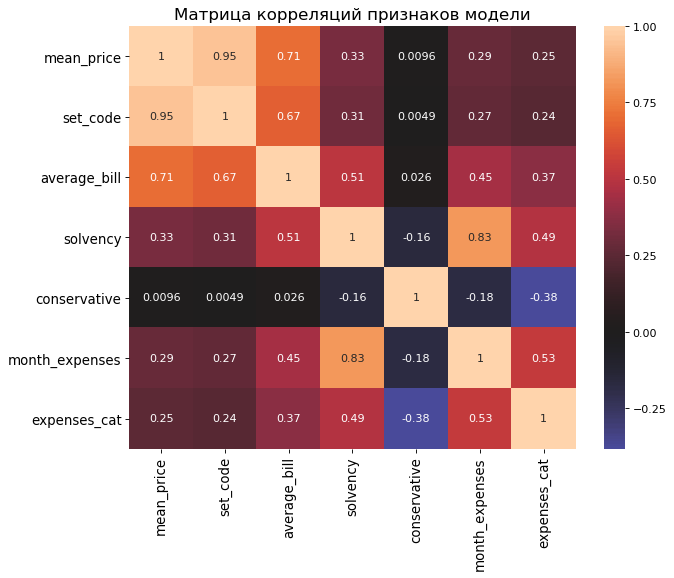

In [66]:
# график корреляций
plt.figure(figsize=(9,7), dpi= 80)
sns.heatmap(X.corr(), xticklabels=X.corr().columns, yticklabels=X.corr().columns, center=0, annot=True)

plt.title('Матрица корреляций признаков модели', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Выявили сильные коррелиции между:

- Признаком количества дней в наборе и цена, по которой пользователь приобрел набор (корреляция 95%)
- Признаком среднемесячных трат пользователя и "платежеспособностью" пользователя (корреляция 83%)

Уберем из набора переменные признаки количества дней в наборе и "платежеспособности".

In [67]:
X = revenue_per_user[['mean_price', 'average_bill', 'conservative', 'month_expenses', 'expenses_cat']]

In [68]:
# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

# список моделей
models = [Lasso(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor(random_state = 42),
          GradientBoostingRegressor(random_state = 42)]

In [70]:
# функция вывода показатели метрик ошибок по моделям
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print('Метрики train:')
    print('MAE:{:.2f} MSE:{:.2f} R2:{:.2f} '.format(mean_absolute_error(y_train, y_train_pred), 
                                          mean_squared_error(y_train, y_train_pred),
                                                                    r2_score(y_train, y_train_pred)))
    
    print('Метрики test:')
    print('MAE:{:.2f} MSE:{:.2f} R2:{:.2f} '.format(mean_absolute_error(y_test, y_test_pred), 
                                          mean_squared_error(y_test, y_test_pred), 
                                                                    r2_score(y_test, y_test_pred)))
    
    print('')
        
# выведем значения метрик по списку моделей
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Метрики train:
MAE:1.10 MSE:7.67 R2:0.00 
Метрики test:
MAE:1.05 MSE:4.88 R2:-0.00 

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Метрики train:
MAE:1.06 MSE:7.14 R2:0.07 
Метрики test:
MAE:1.03 MSE:4.57 R2:0.06 

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
Метрики train:
MAE:0.05 MSE:0.15 R2:0.98 
Метрики test:
MAE:0.98 MSE:5.99 R2:-0.23 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_

Выберем для прогнозирования модели градиентный бустинг

In [71]:
# зададим тестовую выборку для прогноза с вектором новых цен
X_test = revenue_per_user[['new_price', 'average_bill', 'conservative', 'month_expenses', 'expenses_cat']]

# еще раз обучим модель

final_model = GradientBoostingRegressor(random_state = 42)

final_model.fit(X_train, y_train)

# посчитаем вектор целевой переменной
y_pred = final_model.predict(X_test)

In [72]:
revenue_per_user['predict_count']=y_pred

In [73]:
# посчитаем оборот по новой цене и спрогнозируемому числу транзакций

revenue_per_user['predict_revenue']=revenue_per_user['predict_count']*revenue_per_user['new_price']
predict_revenue = revenue_per_user.groupby(['shelter', 'service']).agg({'count':'sum','sum':'sum', 'mean_price':'mean', 'new_price':'mean', 'predict_count':'sum'})

In [74]:
predict_revenue = predict_revenue.reset_index()

In [75]:
# суммарное количество транзакций, текущую и новую ценц преобразуем в целочисленный тип
predict_revenue['predict_count'] = predict_revenue['predict_count'].astype('int')
predict_revenue['mean_price'] = predict_revenue['mean_price'].astype('int')
predict_revenue['new_price'] = predict_revenue['new_price'].astype('int')
# считаем прогнозную выручку по каждому набору в приюте
predict_revenue['new_revenue']=predict_revenue['predict_count']*predict_revenue['new_price']

# обзор суммарных показателей по приютам
summary_dataset = predict_revenue.groupby(['shelter','service']).agg({'mean_price':'mean',
                                                    'new_price':'mean',
                                                    'count':'sum',
                                                    'predict_count':'sum',
                                                    'sum':'sum','new_revenue':'sum'})
summary_dataset

mean_price  new_price  \
shelter                                    service                             
4 лапы                                     пёсодень           155        155   
                                           пёсомесяц         3100       3100   
                                           пёсонеделя         860       1085   
Добрые сердца                              котодень            95        132   
                                           котомесяц         3249       3249   
                                           котонеделя         933        928   
Кот и Пёс                                  котодень            93        101   
                                           котонеделя         710        710   
                                           пёсодень           155        155   
                                           пёсомесяц         3050       3050   
                                           пёсонеделя         800       1085   
Котофей                                    котодень            87        103   
                                           котомесяц         2500       2500   
                                           котонеделя         723        723   
Кошачий приют "ДОМИК"                      котодень            74         98   
                                           котонеделя         686        687   
Лаюшки и Мяушки                            пёсодень           155        155   
                                           пёсонеделя         800       1085   
Люськин дом                                котодень            96        118   
                                           котомесяц         2968       2968   
                                           котонеделя         819        826   
Лёхин дом                                  котодень           127        153   
                                           котомесяц         3745       3745   
                                           котонеделя        1077       1077   
Матроскин                                  котодень            98        117   
                                           котомесяц         3280       3280   
                                           котонеделя         825        825   
Мокрый нос                                 пёсодень           145        145   
                                           пёсомесяц         2530       2530   
                                           пёсонеделя         887       1015   
Приют для кошек "Потеряшка"                котодень           104        124   
                                           котомесяц         3300       3300   
                                           котонеделя         870        870   
Приют для кошек "ЯрКот"                    котодень            87        118   
                                           котомесяц         2835       2835   
                                           котонеделя         832        832   
Самарский приют для животных "НадеждА"     котодень           105        124   
                                           котомесяц         3300       3300   
                                           котонеделя         870        870   
Убежище                                    котодень           117        133   
                                           котомесяц         3373       3373   
                                           котонеделя         937        937   
ФлагманВет                                 котодень            97        126   
                                           котонеделя         886        886   
Центральный приют Спб для бездомных кошек! котодень            98        124   
                                           котонеделя         870        870   
Шереметьевский приют                       пёсодень           285        286   
                                           пёсомесяц         7360       7360   
                                           пёсонеделя  

In [76]:
summary_dataset = summary_dataset.reset_index()

In [77]:
# подготовим датасет для выгрузки в таблицу гугл

summary_dataset.columns = ['Название приюта', 'Название услуги', 'Текущая цена', 'Смоделированная цена',
                           'Текущее кол-во транзакций', 'Смоделированное число транзакций',
                          'Текущий оборот', 'Смоделированный оборот']

In [78]:
# сохраним итоговую таблицу в файл 

#summary_dataset.to_excel('teddy_food.xlsx')

**Сравним суммарную выручку до и после**

In [79]:
revenue_qrowth = predict_revenue.groupby('shelter').agg({'count':'sum', 'sum':'sum', 'predict_count':'sum', 'new_revenue':'sum'})
revenue_qrowth.reset_index()

,shelter,count,sum,predict_count,new_revenue
0,4 лапы,227,54470.0,235,59985
1,Добрые сердца,340,62327.0,634,113006
2,Кот и Пёс,497,115643.0,499,115238
3,Котофей,638,97089.0,549,97921
4,"Кошачий приют ""ДОМИК""",626,78230.0,525,87379
5,Лаюшки и Мяушки,349,81185.0,356,101680
6,Люськин дом,466,88622.0,479,92666
7,Лёхин дом,302,55045.0,263,56663
8,Матроскин,255,45620.0,290,57625
9,Мокрый нос,641,152676.0,611,141185


In [80]:
# посчитаем изменение в числе транзакций и выручки по каждому набору у приютов
    
revenue_qrowth['growth']=((revenue_qrowth['new_revenue']-revenue_qrowth['sum'])/revenue_qrowth['sum'])*100

In [81]:
revenue_qrowth.sort_values('growth')

,count,sum,predict_count,new_revenue,growth
shelter,,,,,
Мокрый нос,641,152676.0,611,141185,-7.526396
Кот и Пёс,497,115643.0,499,115238,-0.350216
Котофей,638,97089.0,549,97921,0.856946
Лёхин дом,302,55045.0,263,56663,2.939413
Люськин дом,466,88622.0,479,92666,4.563201
Шереметьевский приют,147,71880.0,156,75756,5.392321
4 лапы,227,54470.0,235,59985,10.124839
"Кошачий приют ""ДОМИК""",626,78230.0,525,87379,11.695002
"Самарский приют для животных ""НадеждА""",583,104955.0,745,125204,19.293030


У большинства приютов наблюдается рост выручки.

Но у 2х приютов прогноз по выручке после изменения цен упал:

- Мокрый нос - упала выручка на 7,5%
- Кот и Пёс -0,35%

In [82]:
# средний рост выручки по всем приютам

revenue_qrowth['growth'].mean()

39.51595555495535

In [83]:
# суммарное число транзакций

revenue_qrowth[['count', 'predict_count']].sum()

count            6552
predict_count    8112
dtype: int64

<a id="summary"></a>
## Выводы и рекомендации:

Мы провели эксперимент с изменением цен на Кото/ПесоДни и Кото/ПесоНедели, отталкиваясь от идеи предоставлять Недельный набор по той же цене, что и однодневный в эквиваленте 1 дня. Пользователь, покупая Недельный набор по той же цене, что и 7 однодневный, обеспечивает любимого питомца питанием и дополнительно этой покупкой организует запуск рекламной кампании питомца в соц.сетях.

В эксперименте использовали только повышающие рычаги для изменения цен. Изменения касались только однодневных и недельных наборов. 

Для построения прогнозной модели использовали показатели характеристик покупателей, рассчитанные по накопленным историческим данным, такие как:

- средний чек пользователя по всем его транзакциям
- показатель платежеспособности пользователя (основан на суммах, которые пользователь в среднем тратил в день активности в сервисе)
- показатель консерватизма пользователя, показывает насколько пользователь готов экспериментировать и покупать разные услуги
- среднемесячные траты пользователя в сервисе

В результате прогнозная модель показала результаты по увеличению выручки и транзакций у большинства приютов.

<a id="results"></a>
## Ссылка на презентацию проекта

- Презентация - https://drive.google.com/file/d/1zMwoCQgElRzT74psfFMuBOocyJVcKwDK/view?usp=sharing